# 残差GAN
最原始的GAN网络与残差网络结合

In [1]:
import os
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.utils.data
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
# PyTorch TensorBoard support
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import save_image

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
# %% 超参数
if sys.platform.startswith('win'):
    datapath = 'D:\\datasets\\mnist_data'
else:
    datapath = '/home/cxmd/文档/data_for_AI_train/mnist_data/'

n_epochs = 200          # 训练次数
batch_size = 64        # 批大小
lr = 0.00005            # 学习率
b1 = 0.5 
b2 = 0.999
n_cpu = 8               # cpu数量
latent_dim = 100        # 隐变量维度
img_size = 28           # 图片大小
channels = 1            # 图像通道数
n_critic = 5            # 每次迭代判别器训练的次数
clip_value = 0.01       # 
sample_interval = 400   # 每400次迭代保存一次生成的图片

ngpu = 1            # 使用的GPU数量，使用0表示cpu模式

img_shape = (channels, img_size, img_size)

In [4]:
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/ResGan/run1", exist_ok=True)
os.makedirs(r"/home/cxmd/文档/git_files/neural_network/ResGan/images1", exist_ok=True)

In [5]:
# transform配置
transform = transforms.Compose(
    [
        transforms.Resize(img_size),
        transforms.CenterCrop(img_size),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5],std=[0.5]),
    ]
)

In [6]:
# 加载mnist数据，同时将数据按照transform的配置预处理
# 判断是什么操作系统，以设置相应的数据集路径

mnist = dset.MNIST(
    root=datapath,
    train=True,
    transform=transform,
    download=True,
)

In [7]:
# 数据集加载器：GAN为无监督机器学习
# 参数dataset是要加载的数据集，这里是预处理后的mnist数据集
# 参数batch_size是每个批次的样本数量
# 参数shuffle为True表示在每个训练周期开始时，对数据进行重新洗牌
data_loader = torch.utils.data.DataLoader(
    dataset = mnist,
    batch_size=batch_size,
    shuffle=True,
)

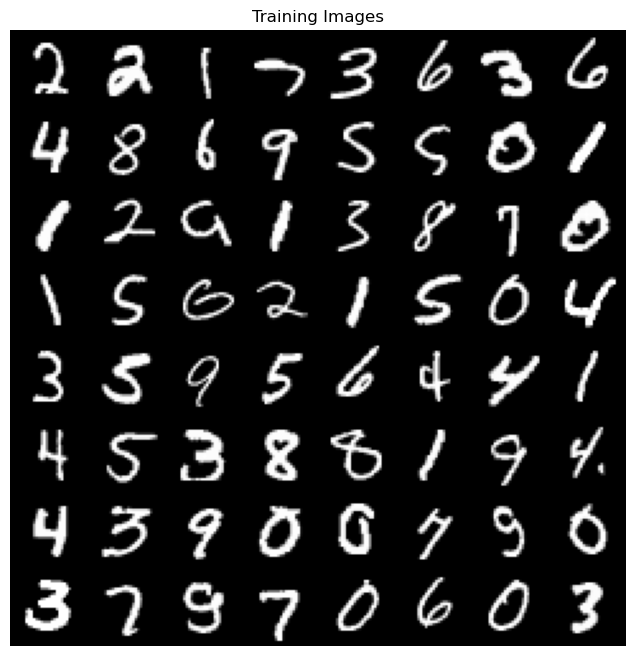

In [8]:
# 绘制部分我们的输入图像
real_batch = next(iter(data_loader))
fig, ax = plt.subplots(figsize=(8, 8))
ax.axis("off")
ax.set_title("Training Images")
ax.imshow(
    vutils.make_grid(
        real_batch[0].to(device)[:64], padding=2, normalize=True
    ).permute(1, 2, 0).cpu()
)
plt.show()

In [9]:
# 定义残差块
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()
        
        self.block = nn.Sequential(
            nn.Linear(in_features, in_features),
            nn.BatchNorm1d(in_features, 0.8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.BatchNorm1d(in_features, 0.8)
        )
        
    def forward(self, x):
        return x + self.block(x)

In [10]:
# 标准GAN生成器
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        
        def block(in_features, out_features, normalize=True):
            layers = [nn.Linear(in_features, out_features)]
            if normalize:
                layers.append(nn.BatchNorm1d(out_features, 0.8))
            layers.append(ResidualBlock(out_features))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers
        
        self.model = nn.Sequential(
            *block(latent_dim, 128, normalize=False),
            *block(128, 256),
            *block(256, 512),
            *block(512, 1024),
            nn.Linear(1024, int(np.prod(img_shape))),
            nn.Tanh()
        )
        
    def forward(self, z):
        img = self.model(z)     # 输入形状为(batch_size, latent_dim)
        img = img.reshape(img.shape[0], *img_shape)  # 输出形状为(batch_size, channels, img_size, img_size)
        return img